# Алгоритмы анализа данных
## Урок 6. Градиентный бустинг (AdaBoost)

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    """Функция, реализующая предсказание в градиентном бустинге.
    """
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    """Функция ошибки
    """
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
def bias(y, z):
    """L2 loss
    """
    return (y - z)

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    """Функция обучения градиентного бустинга.
    """
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [33]:
def get_error_plot(p, train_err, test_err):
    """Графики зависимости ошибки на обучающей и тестовой выборках в зависимости от параметра p
    """
    plt.ylabel('MSE')
    plt.plot(p, train_err, label='train error')
    plt.plot(p, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

### Задание 1

Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
Сделать выводы о зависимости ошибки от этих параметров.

**Решение**

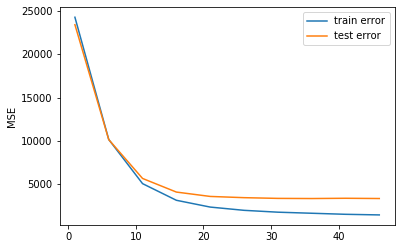

In [35]:
# Варьируем число деревьев в ансамбле
max_depth = 3
eta = 0.1
trees_n = []
train_mse = []
test_mse = []
for n_trees in range(1, 51, 5):
    coefs = [1] * n_trees
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    trees_n.append(n_trees)
    train_mse.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
    test_mse.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
get_error_plot(trees_n, train_mse, test_mse)

При увеличении количества деревьев уменьшается средняя квадратичная ошибка, но после ~20 деревьев уменьшение MSE на тестовой выборке практичски не происходит.

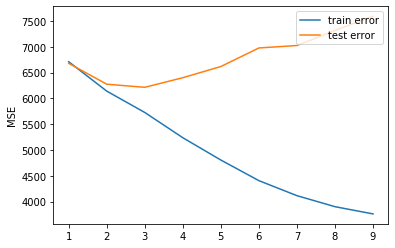

In [34]:
# Варьируем глубину деревьев в ансамбле
eta = 0.1
n_trees = 10
coefs = [1] * n_trees
train_mse = []
test_mse = []
max_depths = []
for max_depth in range(1, 10):
    max_depths.append(max_depth)
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_mse.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
    test_mse.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
get_error_plot(max_depths, train_mse, test_mse)

При увеличении глубины дерева аглоритм быстро переобучается на тренировочной выборке.

### Задание 2*

Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. 
Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

**Решение**

In [49]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    """Функция обучения стохастического градиентного бустинга.
    """
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        # подготавливаем случайную половину датасета для стохастического обучения
        X_train_subset, X_test_subset, y_train_subset, y_test_subset = model_selection.train_test_split(X_train, y_train, test_size=0.50)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево
            tree.fit(X_train_subset, y_train_subset)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_subset, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_subset, bias(y_train_subset, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

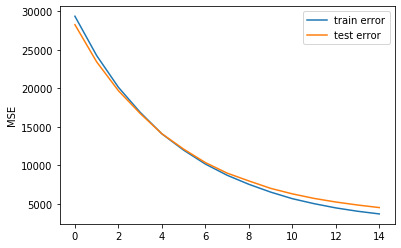

In [50]:
max_depth = 3
eta = 0.1
n_trees = 15
coefs = [1] * n_trees
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
get_error_plot(list(range(n_trees)), train_errors, test_errors)